# PART 1

## Some Imports

In [187]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

import warnings

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from matplotlib import pyplot
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

warnings.filterwarnings('ignore')

## Read data

In [188]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [189]:
X_train.size

47040000

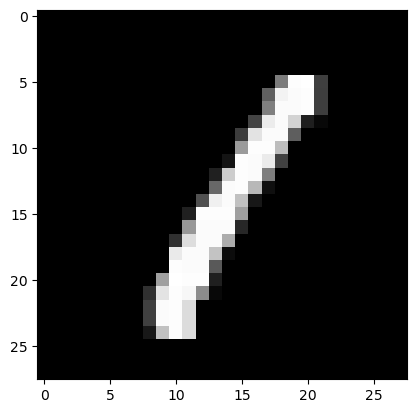

1

In [190]:
pyplot.imshow(X_train[3], cmap=pyplot.get_cmap('gray'))
pyplot.show()
y_train[3]

In [191]:
print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  ' + str(X_test.shape))
print('Y_test:  ' + str(y_test.shape))

MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [192]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (5, 5), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 0, 0, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,031,690 (3.94 MB)

 Trainable params: 1,031,690 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

In [194]:
def load_dataset():
    (trainX, trainY), (testX, testY) = mnist.load_data()
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY


def prep_pixels(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    return train_norm, test_norm


def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def save_model():
    trainX, trainY, testX, testY = load_dataset()
    trainX, testX = prep_pixels(trainX, testX)
    model = define_model()
    model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
    model.save('built_models/final_model.keras')

In [ ]:
save_model()

In [195]:
def run_test_harness():
    trainX, trainY, testX, testY = load_dataset()
    trainX, testX = prep_pixels(trainX, testX)
    model = load_model('built_models/final_model.keras')
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))


run_test_harness()

> 99.130


In [200]:
def load_image(filename):
    img = load_img(filename, color_mode='grayscale', target_size=(28, 28))
    img = img_to_array(img)  # convert to array
    img = img.reshape(1, 28, 28, 1)  # reshape into a single sample with 1 channel
    img = img.astype('float32')  # prepare pixel data
    img = img / 255.0
    return img


def predict_from_image(img):
    img = img.reshape(28, 28)
    model = load_model('built_models/final_model.keras')
    predict_value = model.predict(img)

    for val in predict_value[0]:  # if you see points for each digit 
        print(format(val, '.20f'))

    digit = argmax(predict_value)
    print(digit)


def predict_from_image_path(imgPath):
    img = load_image(imgPath)
    plt.imshow(img.reshape(28, 28), cmap='gray')
    model = load_model('built_models/final_model.keras')
    predict_value = model.predict(img)

    # for val in predict_value[0]: # if you see points for each digit 
    #     print(format(val, '.20f'))

    digit = argmax(predict_value)
    print('Predicted digit:', digit)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted digit: 1


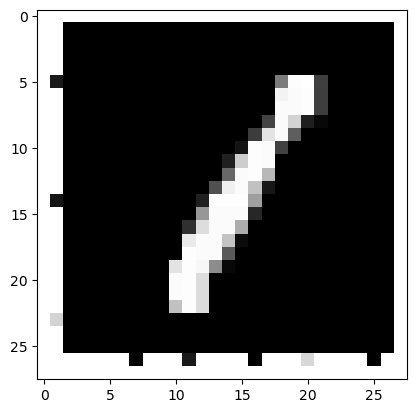

In [201]:
predict_from_image_path('test_images/1.png')

# PART 2

In [202]:
model = tf.keras.models.load_model('built_models/final_model.keras')
optimizer = tf.keras.optimizers.Adam()

learning_rate = 0.01
num_iterations = 1000

desired_output = np.zeros((1, 10))  # desired_output = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
desired_output[0, 3] = 1  # desired_output = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

def generate_input_image(shape=(28, 28, 1)):
    return 0.5 * np.random.random(shape) + 0.5

def optimize_input_image(input_image, desired_output, num_iterations=1000):
    input_tensor = tf.convert_to_tensor(input_image)
    input_tensor = tf.reshape(input_tensor, (1, 28, 28, 1))

    with tf.GradientTape() as tape:
        tape.watch(input_tensor)

        model_output = model(input_tensor)
        loss = loss_fn(desired_output, model_output)

    gradient = tape.gradient(loss, input_tensor)
    gradient = tf.reshape(gradient, (28, 28, 1))

    for i in range(num_iterations):
        input_image -= learning_rate * gradient

    return input_image

def display_input_image(input_image):  # Display input image
    plt.imshow(input_image, cmap='gray')
    plt.show()

def load_img_normalized(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, (28, 28))  # Resize the image to 28x28
    img = img / 255.0  # Normalize the image values to [0, 1]
    img = np.expand_dims(img, axis=2)  # Add a channel dimension
    return img

def input_optimization(input, desired_output):
    if input is None:
        input_image = np.random.rand(28, 28, 1) * 255
    else:
        input_image = load_img_normalized(input)

    optimized_image = optimize_input_image(input_image, desired_output)

    optimized_image = optimized_image.numpy()  # Convert the EagerTensor object to a NumPy array

    if optimized_image.shape[0] == 1:  # Remove the extra dimensions
        optimized_image = np.squeeze(optimized_image, axis=0)
    if optimized_image.shape[2] == 1:
        optimized_image = np.squeeze(optimized_image, axis=2)

    display_input_image(optimized_image)

    return optimized_image

## Random image

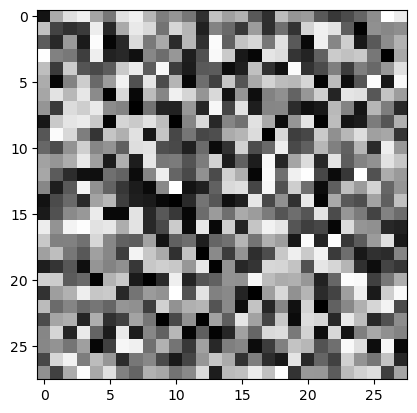

In [205]:
optimized_image = input_optimization(None, desired_output)

## Actual image of the digit with noise added

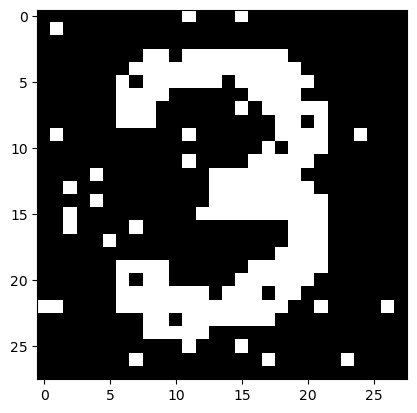

In [206]:
optimized_image2 = input_optimization('test_images/3_noised.png', desired_output)

## For All Digits

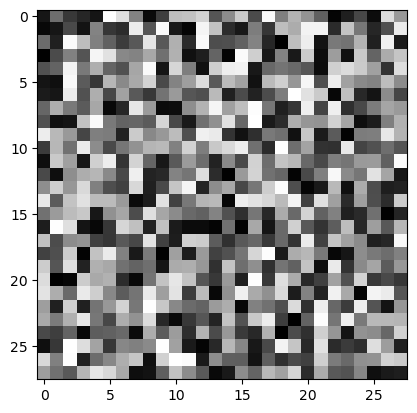

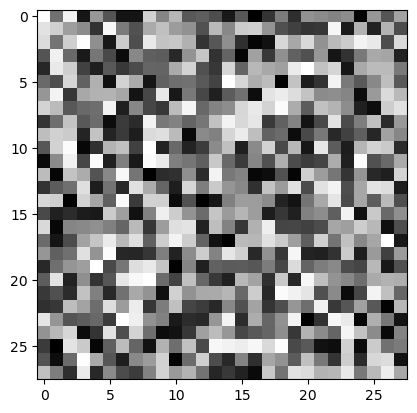

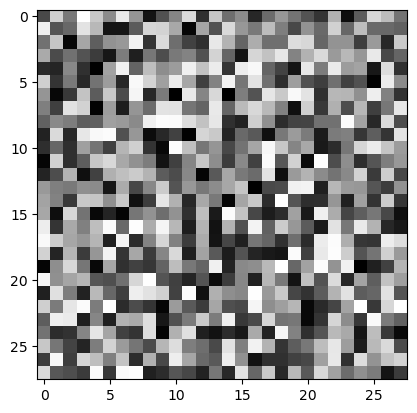

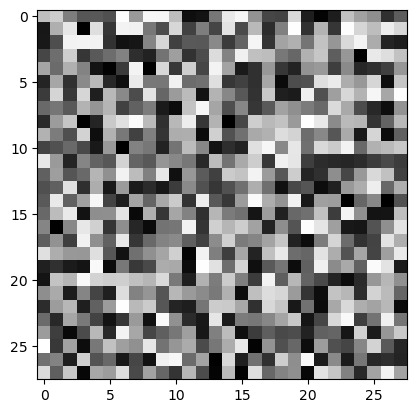

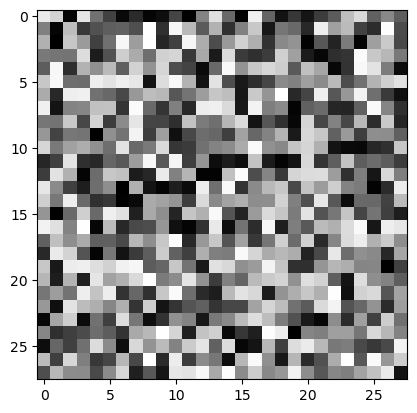

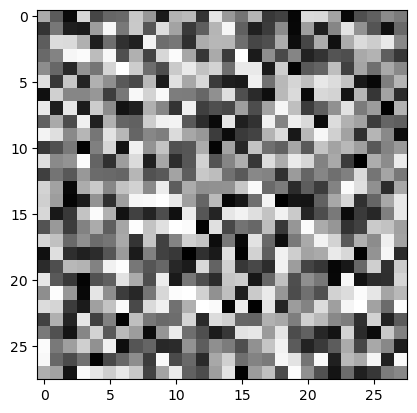

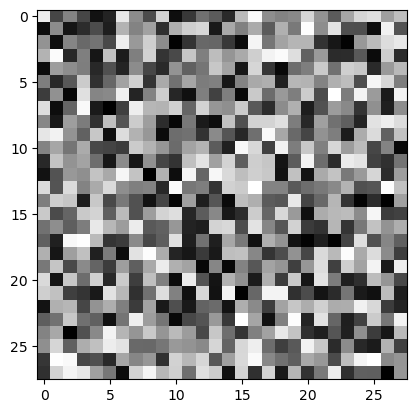

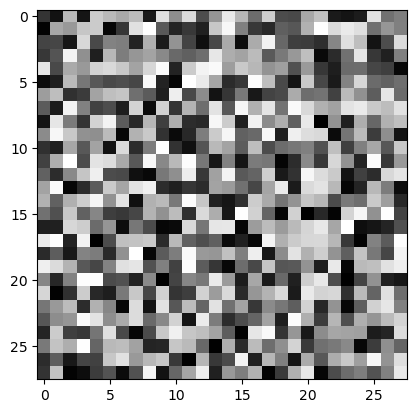

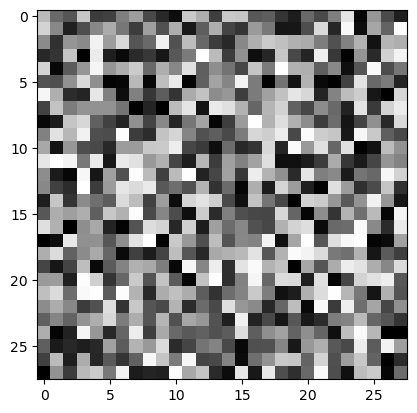

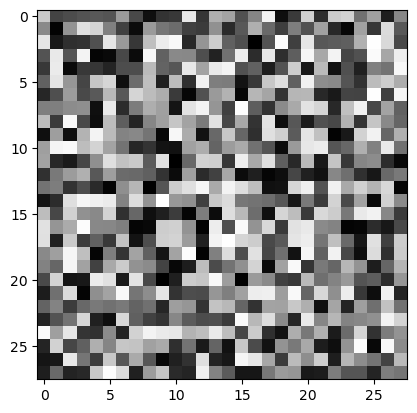

In [207]:
for i in range(10):
    desired_output = np.zeros((1, 10))  # desired_output = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    desired_output[0, i] = 1  # desired_output = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    optimized_image = input_optimization(None, desired_output)

## Between digits 2 and 3.

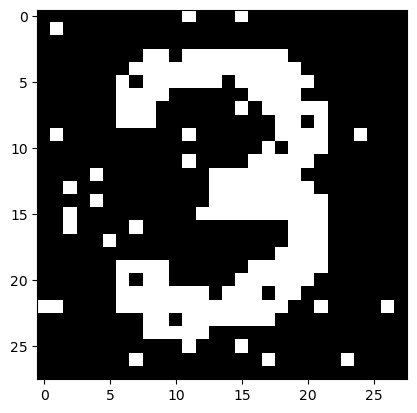

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
0.00000000000000006358
0.00000000000000727947
0.00000000000002776341
1.00000000000000000000
0.00000000000000000002
0.00000000000055607640
0.00000000000000000027
0.00000000000000336042
0.00000000000017954776
0.00000000000176028061


In [213]:
desired_output = np.zeros((1, 10))
desired_output[0, 3] = 1
# optimized_image = input_optimization(None, desired_output)
optimized_image = input_optimization('test_images/3_noised.png', desired_output)
results = model.predict(optimized_image.reshape(1, 28, 28, 1))

for val in results[0]:
    print(format(val, '.20f'))